# Understanding Customer Churn with Clustering

The goal of this notebook is to understand whether or not there are certain clusters of customers that are likely to churn. With this information, we can tailor specific strategies to prevent churn-inclined clusters from leaving the business. This is better than just predicting churn with a neural network because we have actionable insights on how to mitigate customer churn.

In [30]:
#Libraries & Data
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from jupyterthemes import jtplot
jtplot.style(theme='onedork', ticks=True, grid=False)
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

palette = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

df = pd.read_csv('data.csv')

#Renaming some columns
df = df.rename(columns={'customerID': 'Id', 'gender': 'Gender', 'tenure': 'Tenure'})
df

,Id,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


## Exploratory Data Analysis

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The TotalCharges column has an object datatype. This is because each entry in this column as actually a string. In fact, some of the entries in this column are the string with a single space ' '. This is because these customers just joined the company and have zero tenure. In other words, they haven't had to pay yet. We fix this with the below cell.

In [32]:
total_charges = []
for value in df['TotalCharges']:
    try:
        total_charges.append(float(value))
    except:
        total_charges.append(0.)

df['TotalCharges'] = np.array(total_charges)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [33]:
df.isnull().sum()

Id                  0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

No null values!

In [34]:
df.duplicated().sum()

0

No duplicates!

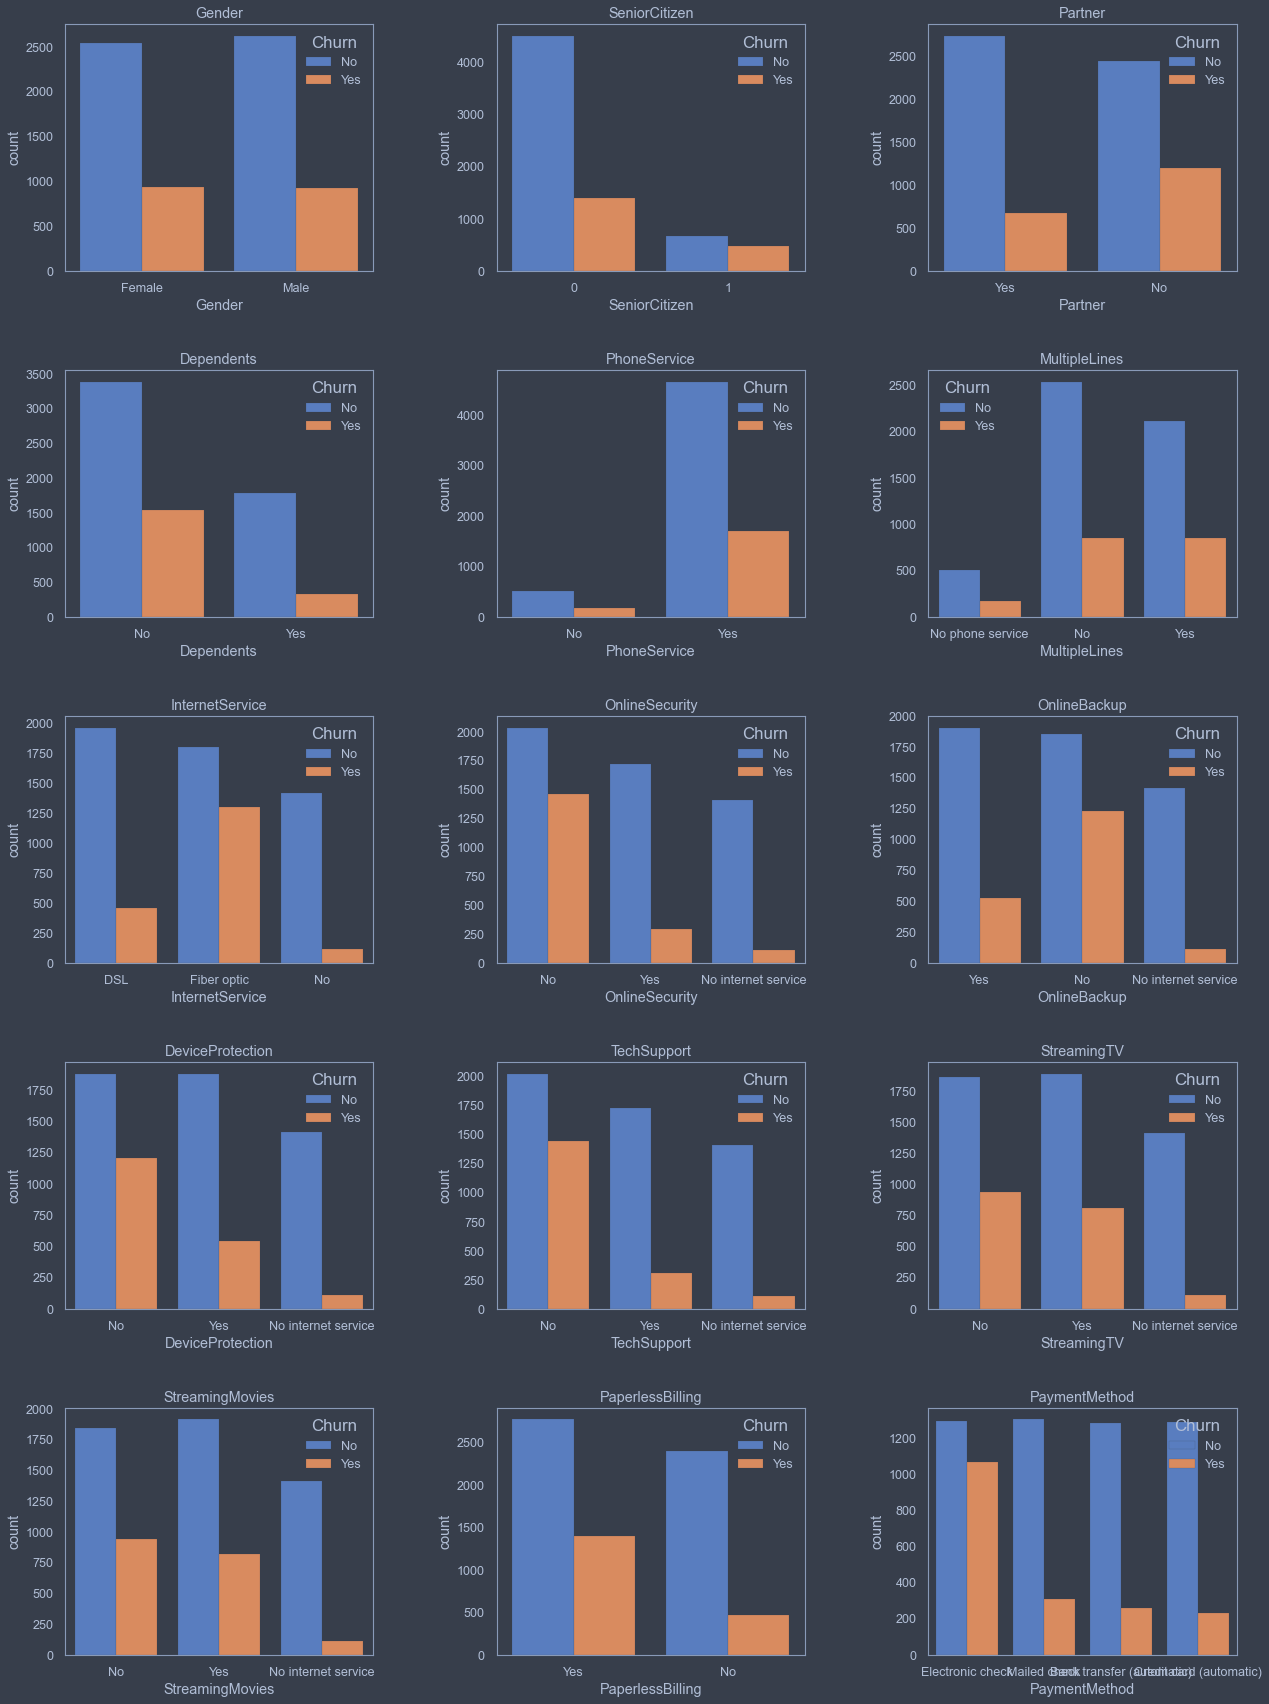

In [35]:
cat_cols = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
            'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
            'PaperlessBilling', 'PaymentMethod']

fig, axes = plt.subplots(5, 3, figsize=(21, 30))
for i in range(5):
    for j in range(3):
        col = cat_cols[3 * i + j]
        sns.countplot(data=df, x=col, hue='Churn', ax=axes[i, j], palette='muted').set_title(col)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

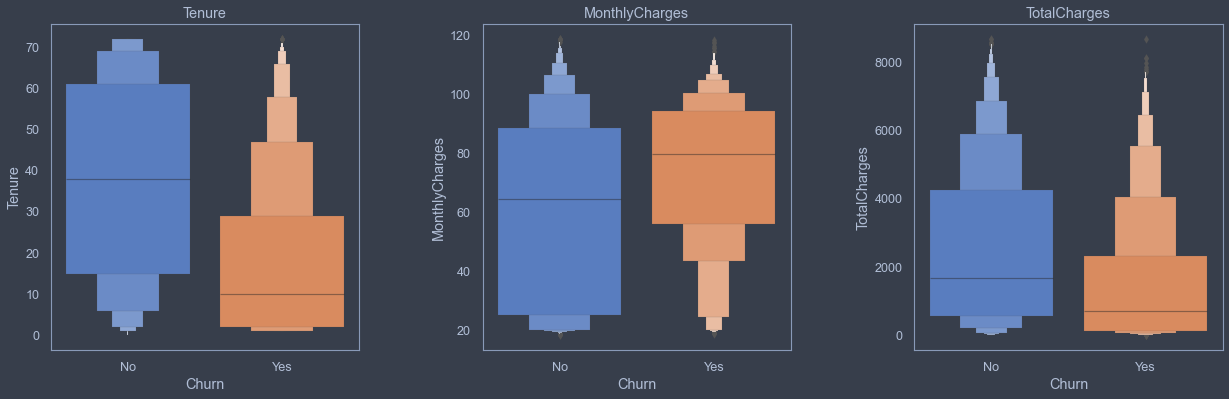

In [36]:
quant_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for i in range(3):
    col = quant_cols[i]
    sns.boxenplot(data=df, x='Churn', y=col, ax=axes[i], palette='muted').set_title(col)
fig.subplots_adjust(wspace=0.4)

The only surprising thing about the above three graphs, is that customers that didn't churn have higher total charges. However, this isn't so surprising after all. Total charges are the cumulative amount the customer has paid over the years. As such, total charges is a very good proxy for tenure. And remember, the more tenure a customer has, the less likely they are to churn. That is to say, customers with higher total charges are less likely to churn because they are "more invested" in the product.

See below for a scatter plot of tenure versus total charges.

Text(0.5, 1.0, 'Tenure versus TotalCharges')

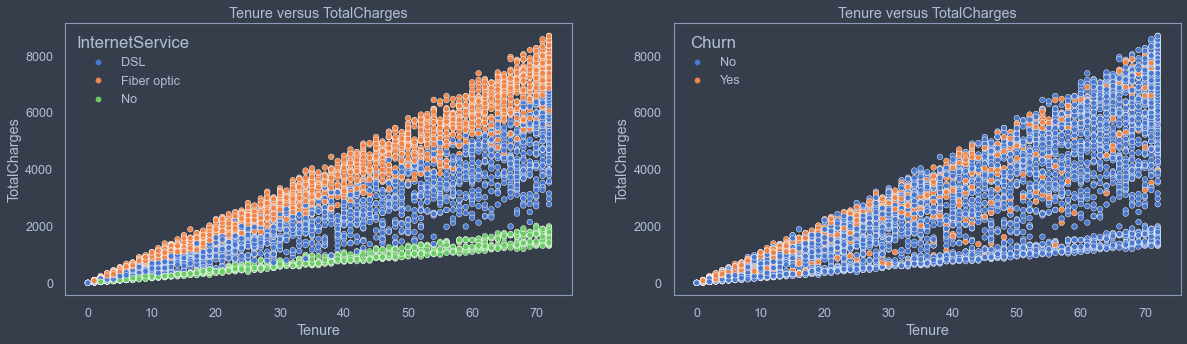

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.scatterplot(data=df, x='Tenure', y='TotalCharges', hue='InternetService', ax=axes[0], palette='muted').set_title('Tenure versus TotalCharges')
sns.scatterplot(data=df, x='Tenure', y='TotalCharges', hue='Churn', ax=axes[1], palette='muted').set_title('Tenure versus TotalCharges')

As we can see from the right graph, the customers most likely to churn are those with the highest slope. What is slope in this context? That's approximately just the monthly charge of the customer. From the left graph, we can see the customers with the highest monthly charge are those with fiber optic. These observations boil down to the fact that fiber optic customers are much more likely to churn, which is confirmed by the countplot of InternetService versus Churn above.

Essentially, the company is charging too much for fiber optic.

Text(0.5, 1.0, 'MonthlyCharges versus Tenure')

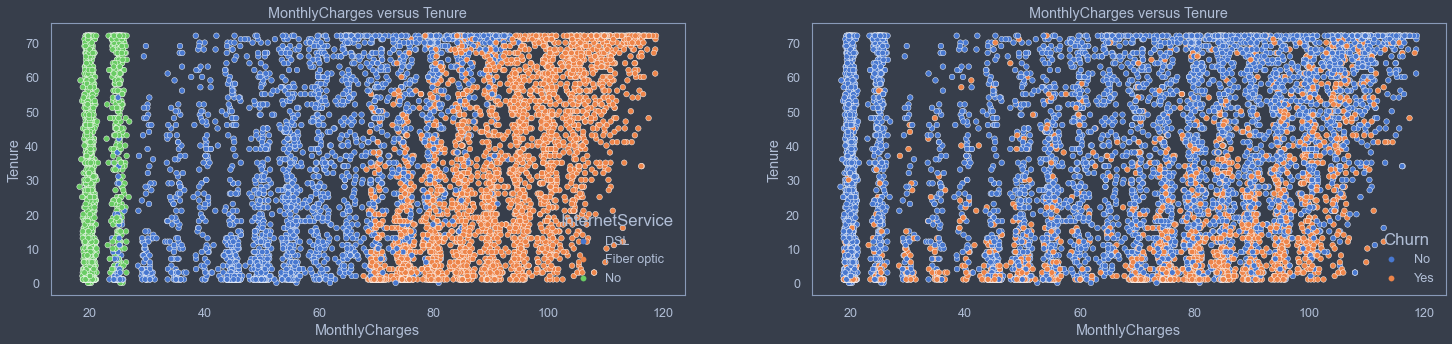

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(25, 5))

sns.scatterplot(data=df, x='MonthlyCharges', y='Tenure', hue='InternetService', ax=axes[0], palette='muted').set_title('MonthlyCharges versus Tenure')
sns.scatterplot(data=df, x='MonthlyCharges', y='Tenure', hue='Churn', ax=axes[1], palette='muted').set_title('MonthlyCharges versus Tenure')

As we can see, customers that churn are likely to have high monthly larges and short tenure with the company.

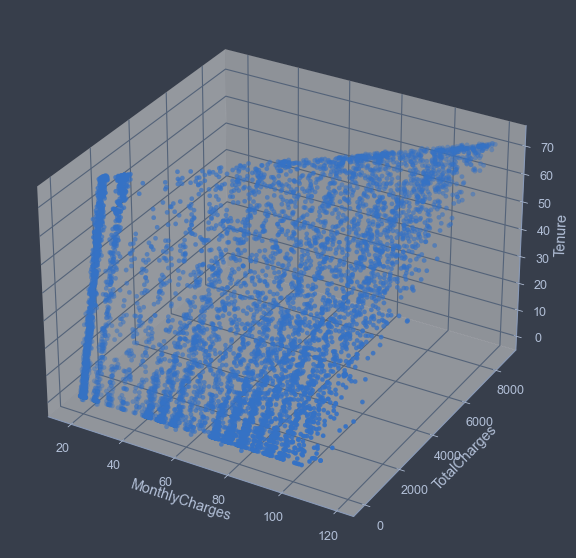

In [39]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('MonthlyCharges')
ax.set_ylabel('TotalCharges')
ax.set_zlabel('Tenure')
ax.scatter(df['MonthlyCharges'], df['TotalCharges'], df['Tenure'])
plt.show()

Text(0.5, 1.0, 'StreamingTV')

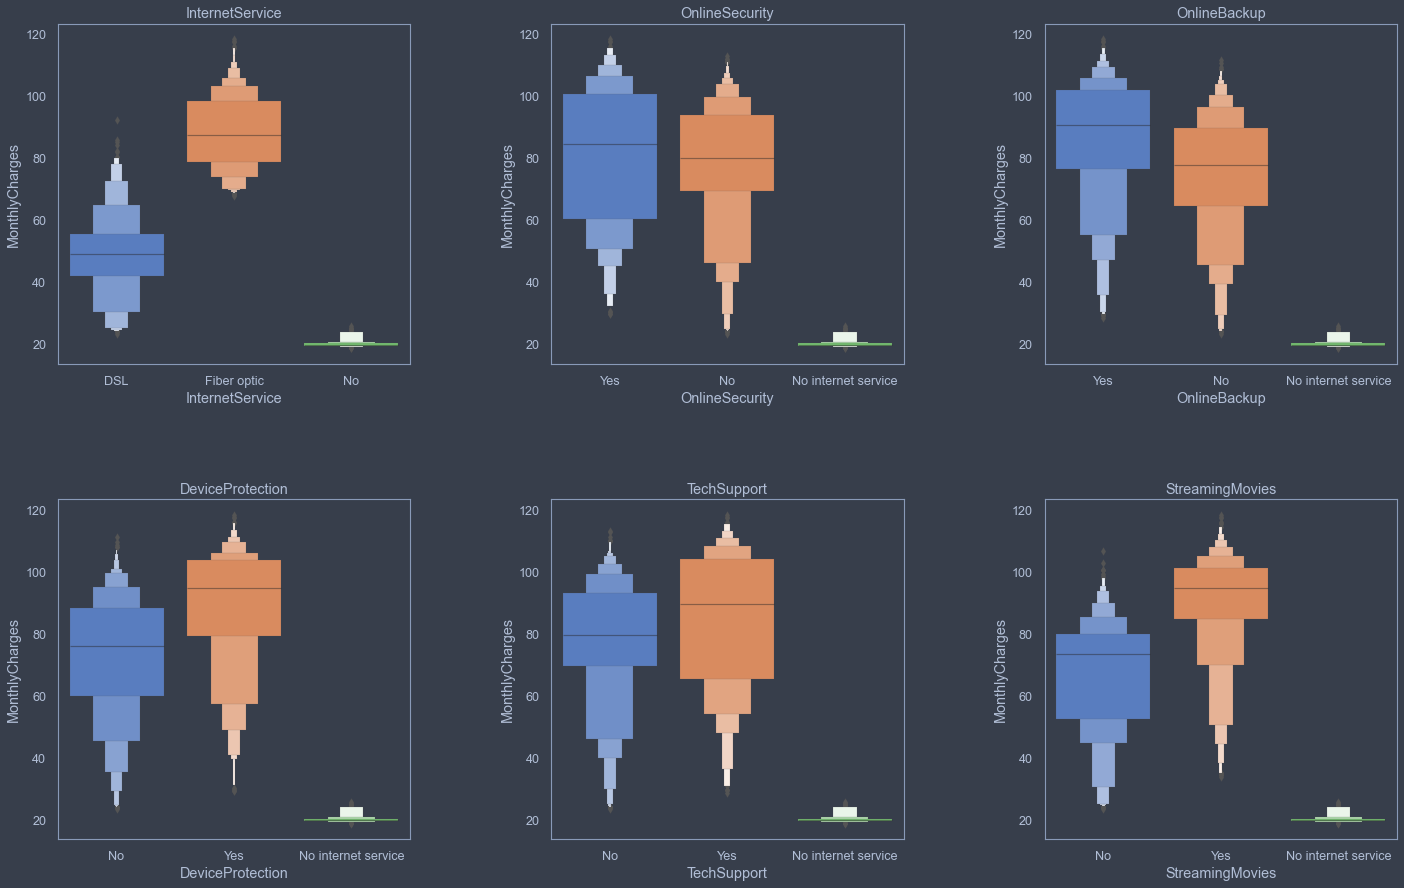

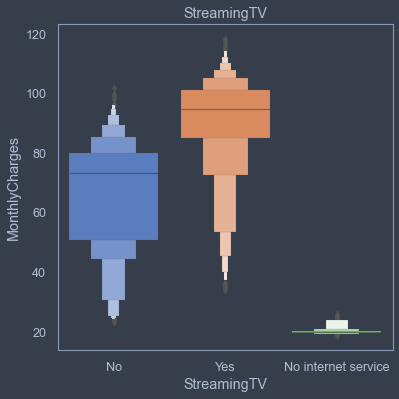

In [69]:
internet_cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies', 'StreamingTV']

fig, axes = plt.subplots(2, 3, figsize=(24, 15))
for i in range(2):
    for j in range(3):
        col = internet_cols[i * 3 + j]
        sns.boxenplot(data=df, x=col, y='MonthlyCharges', ax=axes[i, j], palette='muted').set_title(col)
fig.subplots_adjust(wspace=0.4, hspace=0.4)

fig = plt.subplots(figsize=(6, 6))
sns.boxenplot(data=df, x='StreamingTV', y='MonthlyCharges', palette='muted').set_title('StreamingTV')

## Key Takeways from Exploratory Data Analysis
 1. People with partners or dependents are less likely to churn. 
 2. People with Fiber Optic are very likely to churn, whereas people with no internet service are unlikely to churn.
 3. People with OnlineSecurity, OnlineBackup, DeviceProtection, or TechSupport are much less likely to churn than those without.
 4. People with electronic checks are much more likely to churn than with any other payment method.
 5. People with short tenure at the company are more likely to churn.
 6. People with high monthly charges are more likely to churn.
 7. Fiber Optic is the most expensive internet service, leading to the highest monthly charges and greatest churn rates.
 8. OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, and Streaming all contribute to higher monthly charges.

## Cleaning the data

Most of our variables are categorical. Let's translate our text values to numerical values. This will make the pandas.DataFrame.describe() method useful later on and is a necessary step for machine learning algorithms.

In [41]:
clean_df = df.copy()

#Yes/No columns
yes_no_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
yes_no_dict = {'Yes': 1, 'No': 0}
for col in yes_no_cols:
    clean_df[col] = clean_df[col].map(yes_no_dict)
    
#Internet columns
internet_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
internet_dict = {'No internet service': -1, 'No': 0, 'Yes': 1}
for col in internet_cols:
    clean_df[col] = clean_df[col].map(internet_dict)
    
#Miscellaneous columns
gender_dict = {'Male': 1, 'Female': 0}
clean_df['Gender'] = clean_df['Gender'].map(gender_dict)

multiple_lines_dict = {'No phone service': -1, 'No': 0, 'Yes': 1}
clean_df['MultipleLines'] = clean_df['MultipleLines'].map(multiple_lines_dict)

internet_service_dict = {'No': -1, 'DSL':0, 'Fiber optic':1}
clean_df['InternetService'] = clean_df['InternetService'].map(internet_service_dict)

contract_dict = {'Month-to-month': 12e-1, 'One year': 1, 'Two year': 2}
clean_df['Contract'] = clean_df['Contract'].map(contract_dict)

payment_method_dict = {'Electronic check': -1, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3}
clean_df['PaymentMethod'] = clean_df['PaymentMethod'].map(payment_method_dict)

#Drop the Id column
clean_df = clean_df.drop(columns=['Id'])

clean_df

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,-1,0,0,1,0,0,0,0,1.2,1,-1,29.85,29.85,0
1,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1.0,0,1,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,1.2,1,1,53.85,108.15,1
3,1,0,0,0,45,0,-1,0,1,0,1,1,0,0,1.0,0,2,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,1.2,1,-1,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,0,1,0,1,1,1,1,1.0,1,1,84.80,1990.50,0
7039,0,0,1,1,72,1,1,1,0,1,1,0,1,1,1.0,1,3,103.20,7362.90,0
7040,0,0,1,1,11,0,-1,0,1,0,0,0,0,0,1.2,1,-1,29.60,346.45,0
7041,1,1,1,0,4,1,1,1,0,0,0,0,0,0,1.2,1,1,74.40,306.60,1


In [42]:
clean_df.describe()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,32.371149,0.903166,0.325004,0.222916,0.069999,0.128212,0.127219,0.073548,0.167684,0.171234,1.350703,0.592219,0.979838,64.761692,2279.734304,0.265370
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.642730,0.778877,0.706051,0.738369,0.737868,0.708201,0.756958,0.758507,0.373764,0.491457,1.557801,30.090047,2266.794470,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,0.000000,-1.000000,18.250000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.200000,0.000000,-1.000000,35.500000,398.550000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.200000,1.000000,1.000000,70.350000,1394.550000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.200000,1.000000,2.000000,89.850000,3786.600000,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,1.000000


As mentioned above, the desribe() method is more useful after switching to numeric values. For example, looking at the mean for SeniorCitizen, we conclude that 16.2% of our customers are senior citizens.

Let's begin to understand how are variables are related to one another by graphing our correlation matrix.

<AxesSubplot:>

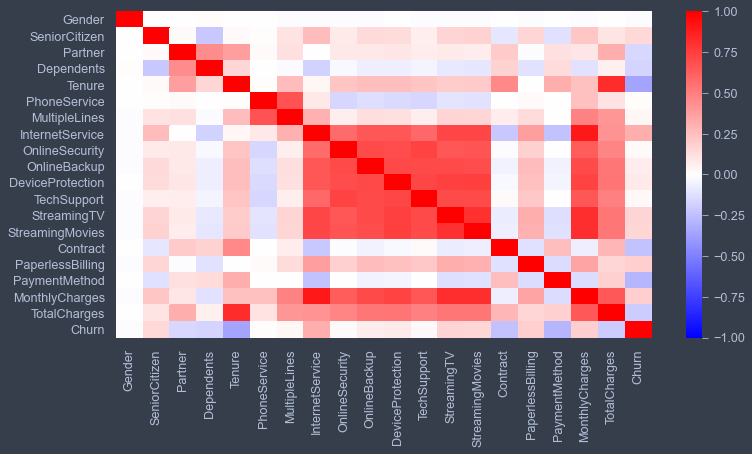

In [43]:
corr = clean_df.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr, vmin=-1, vmax=1, cmap='bwr')

Interesting. As we can see, the internet related variables are highly correlated. Also, monthly charges are highly correlated with internet service.

What variables are related to churn?
 - Tenure, Contract, PaymentMethod: Customers with automatic payments, longer tenure, and longer contracts are less likely to churn.
 - InternetService: Customers with internet service are more likely to churn.

In [44]:
p1 = len(clean_df.loc[(clean_df['Churn'] == 1) & (clean_df['InternetService'] == 1)]) / len(clean_df.loc[clean_df['InternetService'] == 1])
p2 = len(clean_df.loc[(clean_df['Churn'] == 1) & (clean_df['InternetService'] == 0)]) / len(clean_df.loc[clean_df['InternetService'] == 0])
p3 = len(clean_df.loc[(clean_df['Churn'] == 1) & (clean_df['InternetService'] == -1)]) / len(clean_df.loc[clean_df['InternetService'] == -1])
print('P(Churn = 1 | InternetService = 1) = {}%'.format(round(p1 * 100), 2))
print('P(Churn = 1 | InternetService = 0) = {}%'.format(round(p2 * 100), 2))
print('P(Churn = 1 | InternetService = -1) = {}%'.format(round(p3 * 100), 2))

P(Churn = 1 | InternetService = 1) = 42%
P(Churn = 1 | InternetService = 0) = 19%
P(Churn = 1 | InternetService = -1) = 7%


Given that a customer has internet service, there is a 42% chance that the customer churned. Given that the churn rate across all our data points is 26%, that is a very large number!

## Scaling the data and focusing on churned customers

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_df = scaler.fit_transform(clean_df.to_numpy())
scaled_df = pd.DataFrame(scaled_df, columns=clean_df.columns)

#Let's focus our attention on customers that actually churned
scaled_df = scaled_df.loc[scaled_df['Churn'] > 0]
clean_df = clean_df.loc[clean_df['Churn'] == 1]
df = df.loc[df['Churn'] == 'Yes']
df

,Id,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
13,0280-XJGEX,Male,0,No,No,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,1699-HPSBG,Male,0,No,No,12,Yes,No,DSL,No,No,No,Yes,Yes,No,One year,Yes,Electronic check,59.80,727.80,Yes
7026,8775-CEBBJ,Female,0,No,No,9,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,Yes
7032,6894-LFHLY,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,75.75,75.75,Yes
7034,0639-TSIQW,Female,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),102.95,6886.25,Yes


## Principal Component Analysis

In this dataset, there are a number of highly correlated features. For example, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies are all positively correlated with one another. With so many highly correlated features, dimensionality reduction can surely be of use. We will use Principal Component Analysis to achieve this aim.

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(scaled_df)
PCA_df = pd.DataFrame(pca.transform(scaled_df), columns=['col1', 'col2', 'col3'])
PCA_df

,col1,col2,col3
0,1.150527,0.159617,-0.144480
1,1.028864,-0.843912,0.177498
2,-1.157270,-0.900070,0.049418
3,-2.318288,0.191499,-0.524200
4,-2.530953,0.467331,-0.923419
...,...,...,...
1864,0.741006,0.007414,0.186966
1865,1.729205,-0.159190,-0.524362
1866,0.009378,-2.110170,1.689414
1867,-2.788764,0.848117,-1.431600


Let's graph the PCA dataframe in 3d space.

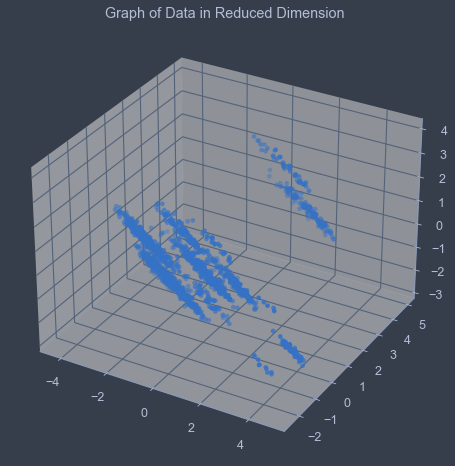

In [47]:
x = PCA_df['col1']
y = PCA_df['col2']
z = PCA_df['col3']
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, marker='o')
ax.set_title('Graph of Data in Reduced Dimension')
plt.show()

## Clustering

In [48]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Elbow_M = KElbowVisualizer(KMeans(), k=10)
# Elbow_M.fit(PCA_df)
# Elbow_M.show()

According to the elbow method, we should use five clusters.

In [49]:
from sklearn.cluster import AgglomerativeClustering

AC = AgglomerativeClustering(n_clusters=5)
predict_AC = AC.fit_predict(PCA_df)
PCA_df['Clusters'] = predict_AC
df['Clusters'] = predict_AC.astype(object)
df

<ipython-input-49-06dbbeb790b5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Clusters'] = predict_AC.astype(object)


,Id,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Clusters
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,0
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1
13,0280-XJGEX,Male,0,No,No,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,1699-HPSBG,Male,0,No,No,12,Yes,No,DSL,No,No,No,Yes,Yes,No,One year,Yes,Electronic check,59.80,727.80,Yes,0
7026,8775-CEBBJ,Female,0,No,No,9,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,Yes,0
7032,6894-LFHLY,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,75.75,75.75,Yes,4
7034,0639-TSIQW,Female,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),102.95,6886.25,Yes,1


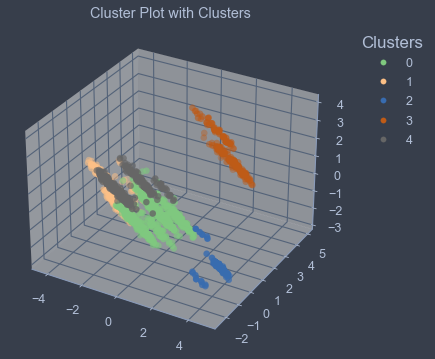

In [50]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d', label='bla')
sp = ax.scatter(x, y, z, s=40, c=PCA_df['Clusters'], marker='o', cmap='Accent')
ax.set_title('Cluster Plot with Clusters')
plt.legend(*sp.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2, title='Clusters')
plt.show()

## Analyzing our clusters

Let's look at the distributions of our clusters.

Text(0.5, 1.0, 'Cluster Distribution')

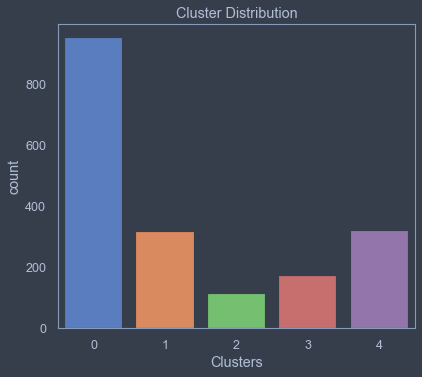

In [51]:
sns.countplot(x=df['Clusters'], palette='muted').set_title('Cluster Distribution')

As we can see, most of our customers are in Cluster 0, so this would be a good cluster to focus retention efforts on. Also, Clusters 1 and 4 are the next most popular clusters.

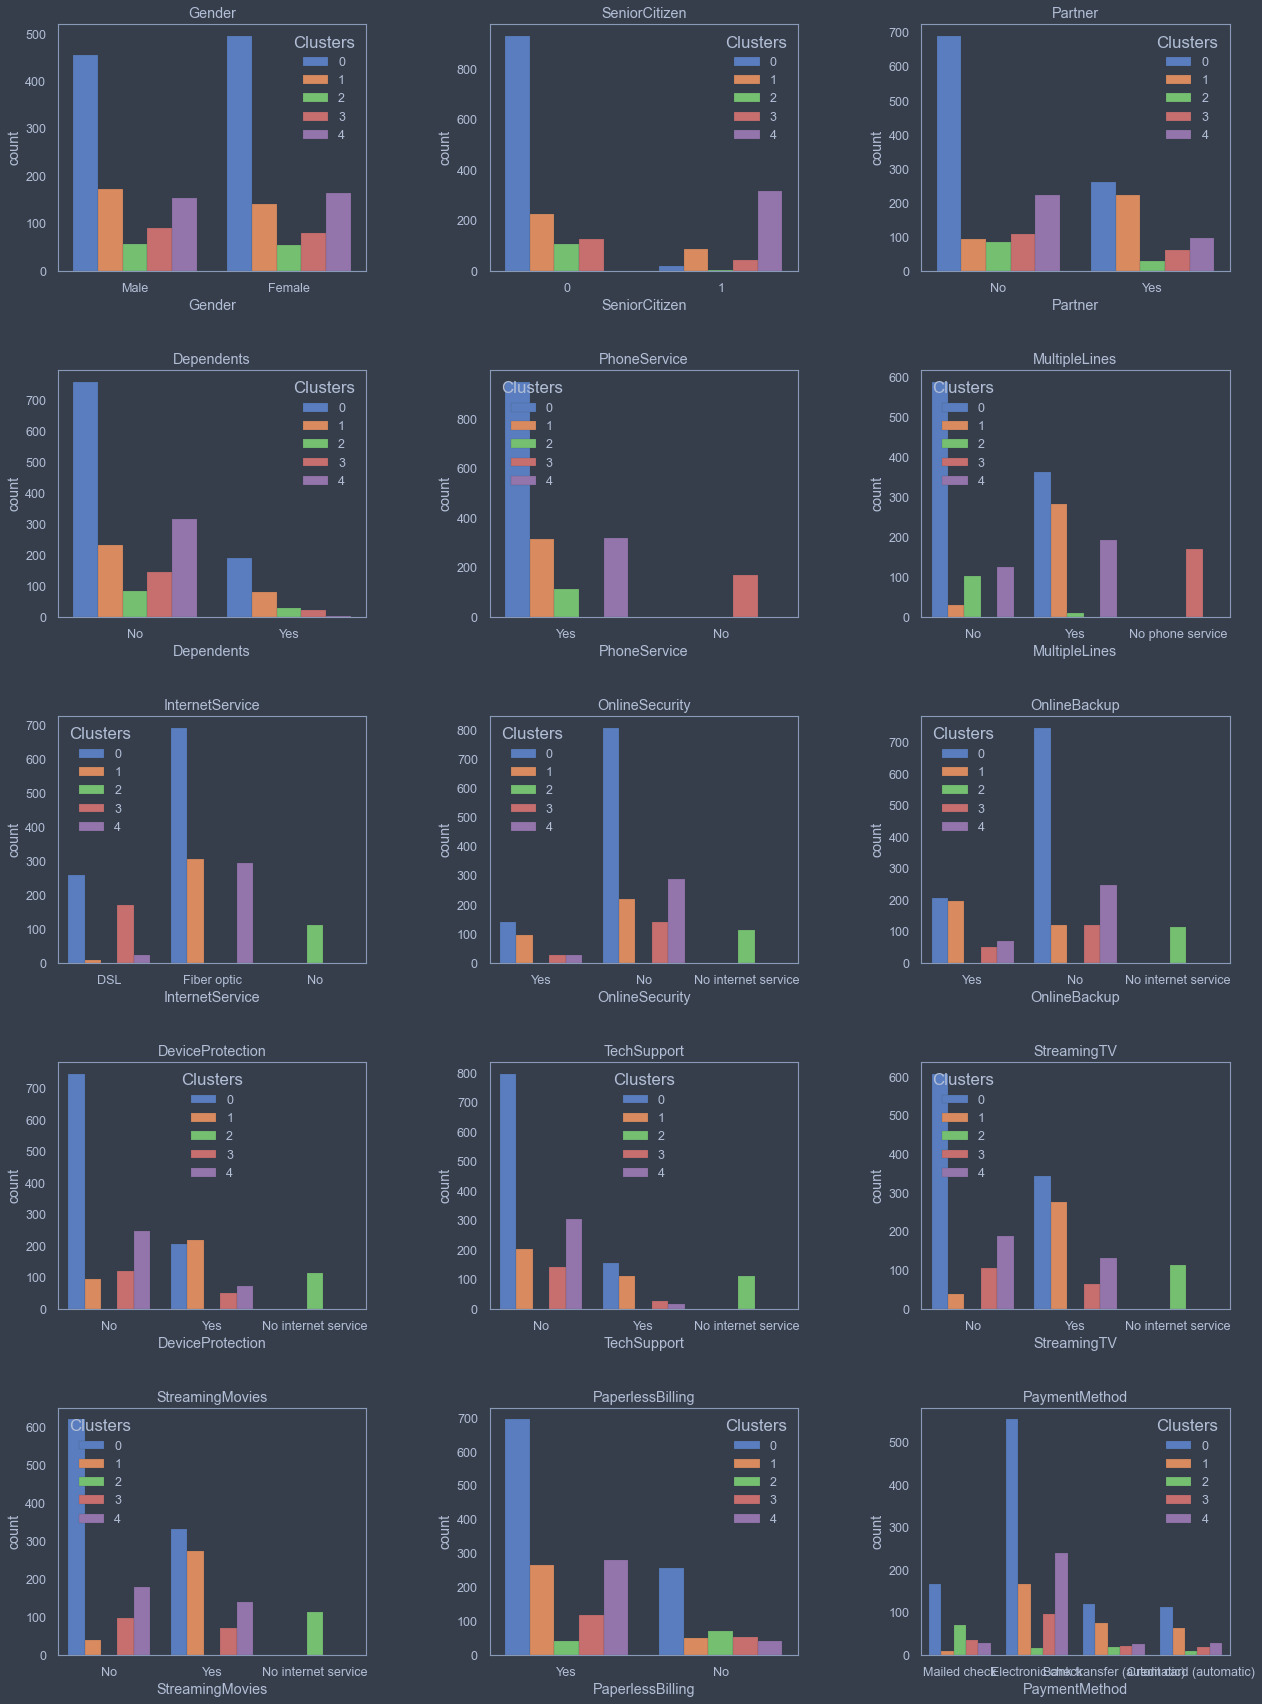

In [52]:
fig, axes = plt.subplots(5, 3, figsize=(21, 30))
for i in range(5):
    for j in range(3):
        col = cat_cols[3 * i + j]
        sns.countplot(data=df, x=col, hue='Clusters', ax=axes[i, j], palette='muted').set_title(col)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

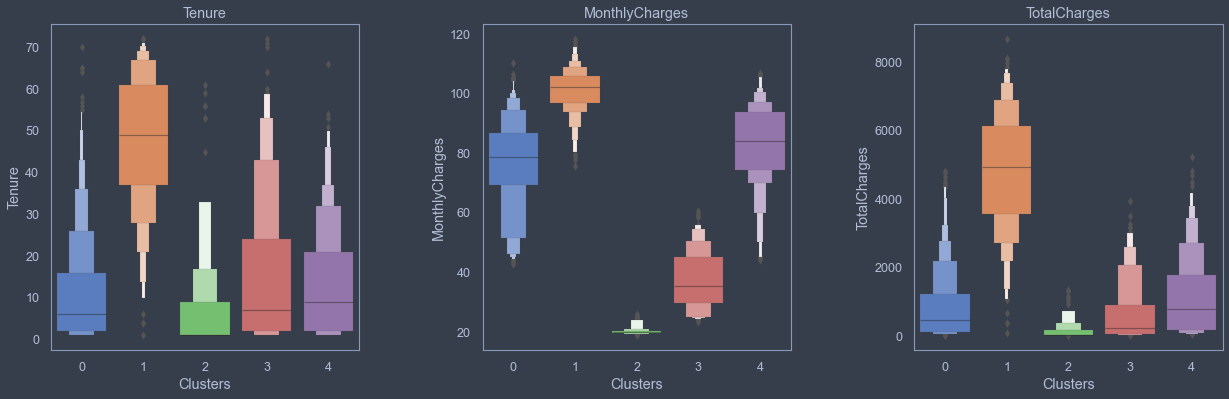

In [53]:
quant_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for i in range(3):
    col = quant_cols[i]
    sns.boxenplot(data=df, x='Clusters', y=col, ax=axes[i], palette='muted').set_title(col)
fig.subplots_adjust(wspace=0.4)

Text(0.5, 1.0, 'MonthlyCharges versus Tenure')

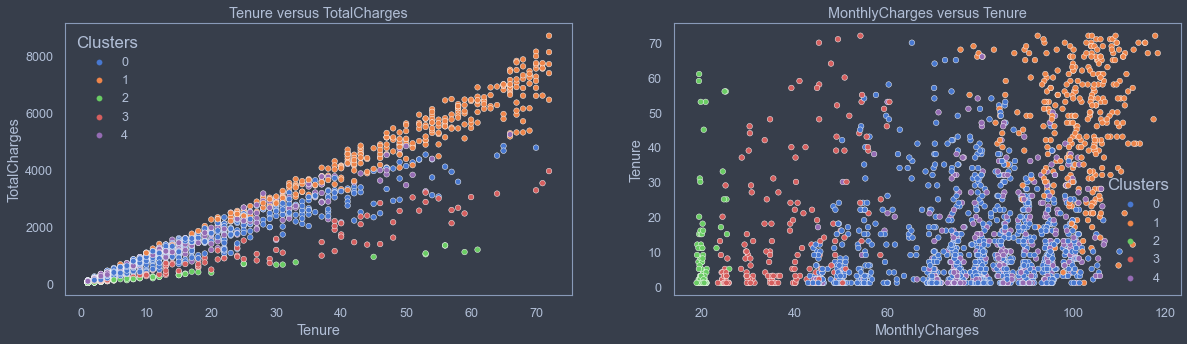

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.scatterplot(data=df, x='Tenure', y='TotalCharges', hue='Clusters', ax=axes[0], palette='muted').set_title('Tenure versus TotalCharges')
sns.scatterplot(data=df, x='MonthlyCharges', y='Tenure', hue='Clusters', ax=axes[1], palette='muted').set_title('MonthlyCharges versus Tenure')

# Key Cluster Takeaways

**Cluster 0**
 - Younger - never senior citizens
 - Typically don't have partner or dependents
 - Most have phone service and use Fiber Optic
 - Typically don't have OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport
     - These factors are protective against churn and these customers are missing them
 - Typically do stream movies and tv
 - Most receive an electronic check
     - Electronic checks are associated with higher churn rates

Cluster 0 is full of younger, single, tech savvy people. They typically use fiber optic for streaming purposes and don't have much internet protection. As such, they have high monthly charges while getting very little protection. This is not good in terms of preventing churn.

**What are some strategies to retain Cluster 0 customers?**
 - Encourage these users to cut back on streaming, and use those saving for online security and tech support.
     - Send mailouts describing how cheap and effective device protection is.
 - See if we can switch them to any other payment method besides electronic check.
     - Email them, asking permission to switch payment method.
     
     
**Cluster 1**
 - Most have multiple phone lines (higher monthly charge)
 - Almost all have fiber optic (higher monthly charge)
 - Almost all stream TV and movies (higher monthly charge)
 - This cluster has the highest tenure out of any other cluster by far which is very surprising since tenure typically protects against churn
 - This cluster has the highest monthly charges out of all clusters
 
Cluster 1 is a bit of an outlier since these customers have very high tenure, yet are still churning, probably due to their high monthly charges. 
 
**What are some strategies to retain Cluster 1 customers?**
  - Look into whether or not these customers high monthly charges was a recent phenonomenon (maybe they recently switche to fiber optic or added more phone lines)
      - This would explain why they've been with the company for so long, but are only now leaving
  - Appeal to their history with the company
  
**Cluster 2**
 - Only use phone service
 - Don't use internet service
 - Lowest monthly charges
 
 Cluster 2 users are people that exclusively have phone service and no internet service.
 
**What are some strategies to retain Cluster 2 customers?**
  - Offer incentive for bundling internet and phone service
  - Offer a form of protection for phone services
  
**Cluster 3**
 - Only use internet service
 - Only use DSL
 - Relatively low monthly charges
     - This is unusual: most customers that churn with internet are fiber optic users
 - Don't use phone service at all
 
Cluster 3 users only have DSL and have no phone service.
 
**What are some strategies to retain Cluster 2 customers?**
  - Offer incentive for bundling internet and phone service
  - Lower prices for DSL
  
**Cluster 4**
 - All senior citizens
 - All have no dependents
 - All have phone service
 - Almost all have fiber optic
 - Most don't have internet protection
 - Most don't stream tv or movies
 - Most have electronic check
 - Second highest montly charges out of all clusters
 - Short tenure with company
 
Cluster 4 consists entirely of senior citizens using fiber optic, with no internet protection. Strangely, they have very high monthly charges considering they don't have internet protection or stream. 

**What are some strategies to retain Cluster 1 customers?**
  - Lower price for mutiple phone lines and fiber optic (these customers have high pricing despite no steaming and no protection)
  - Give a senior citizen discount